Change the data path before running

In [ ]:
import numpy as np
import polars as pl
from PIL import Image
import random
import pandas as pd
import matplotlib.pyplot as plt
import math

gt_image_path = '/content/drive/MyDrive/3dgs/data/pre-trained/3DGS/playroom/train/ours_30000/gt/00020.png'
render_image_path = '/content/drive/MyDrive/3dgs/data/pre-trained/3DGS/playroom/train/ours_30000/renders/00020.png'
dataset_path = '/content/drive/MyDrive/3dgs/gaussian-splatting/alpha_vals.csv'

In [ ]:
df = pl.read_csv(dataset_path)
print(df.head())

### Reconstruct Image
We conduct color accumulation to reproduce rendered image, proving the correctness of data

In [ ]:
import polars as pl
import numpy as np
from PIL import Image

required_columns = ['pixelNum', 'out_color_r', 'out_color_g', 'out_color_b']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"CSV file must contain the columns: {required_columns}")

# Extract RGB color values as NumPy arrays
r_values = df['out_color_r'].to_numpy()
g_values = df['out_color_g'].to_numpy()
b_values = df['out_color_b'].to_numpy()

image = Image.open(render_image_path)
width, height = image.size
image_array = np.zeros((height, width, 3), dtype=np.uint8)

# Populate the image array using row-major order from 'pixelNum'
pixel_nums = df['pixelNum'].to_numpy()
for i in range(len(df)):
    pixel_num = int(pixel_nums[i])
    x = pixel_num % width
    y = pixel_num // width
    if 0 <= x < width and 0 <= y < height:
        image_array[y, x] = [r_values[i] * 255, g_values[i] * 255, b_values[i] * 255]

# Convert the NumPy array to an image
final_image = Image.fromarray(image_array)
final_image.show() 
final_image.save('/content/reconstructed_image_out.png')
print("Image reconstructed and saved!")

685241
Image reconstructed and saved!


Reading CSV Chunks:   0%|          | 0/53 [00:00<?, ?it/s]

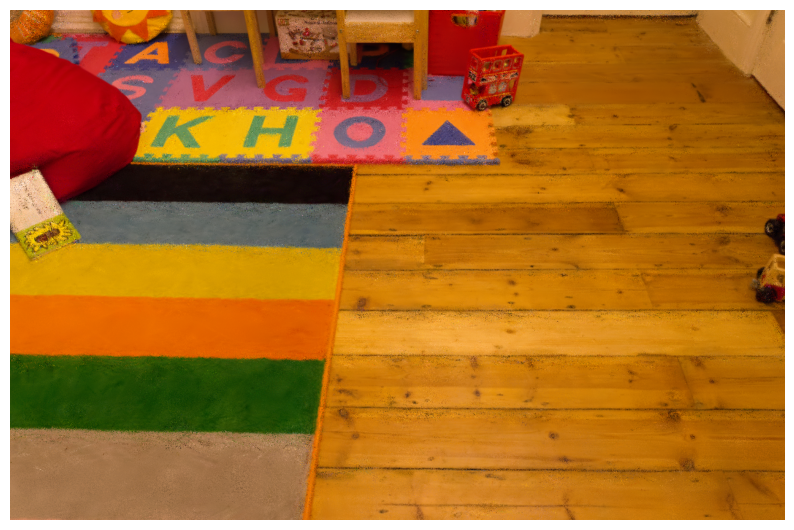

Reconstructed image saved!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def color_accum_numpy(splats):
    """
    Optimized implementation of color accumulation using NumPy.
    """
    T = np.ones(splats.shape[0], dtype=np.float32)  # Transparency values
    r = g = b = np.zeros(splats.shape[0], dtype=np.float32)  # RGB accumulators

    for splat in splats.T:
        alpha, depth, color_r, color_g, color_b = splat
        r += T * alpha * color_r
        g += T * alpha * color_g
        b += T * alpha * color_b
        T *= (1 - alpha)
        if np.all(T <= 0.001):
            break

    return np.clip(r * 255, 0, 255).astype(np.uint8), \
           np.clip(g * 255, 0, 255).astype(np.uint8), \
           np.clip(b * 255, 0, 255).astype(np.uint8)

image = Image.open('/content/drive/MyDrive/3dgs/data/pre-trained/3DGS/playroom/train/ours_30000/renders/00020.png')
width, height = image.size
reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)

splats = df.to_numpy()
x = (splats[:, 0] % width).astype(int)
y = (splats[:, 0] // width).astype(int)

splat_data = splats[:, 7:].reshape(-1, 5)
rgb_values = color_accum_numpy(splat_data)

# Populate the image array
reconstructed_image[y, x] = np.stack(rgb_values, axis=-1)
final_image = Image.fromarray(reconstructed_image)

# Display the reconstructed image
plt.figure(figsize=(10, 8))
plt.imshow(final_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Optionally, save the image
final_image.save("/content/reconstructed_image.png")
print("Reconstructed image saved!")

## Clustering Algorithm

In [ ]:
def orig_color_accum(depth, alpha, color, final_color, final_alpha):
  final_color = (
              final_color[0] + final_alpha * alpha * color[0],
              final_color[1] + final_alpha * alpha * color[1],
              final_color[2] + final_alpha * alpha * color[2],
          )
  final_alpha *= (1 - alpha)
  return final_alpha, final_color

def commutative_accum(depth, alpha, color, final_color, final_alpha):
  final_color = (
              final_color[0] + alpha * color[0],
              final_color[1] + alpha * color[1],
              final_color[2] + alpha * color[2],
          )
  final_alpha *= (1 - alpha)
  return final_alpha, final_color

# Add alpha-correction
def alpha_correction(alpha, samples):
  alpha = 1 - (1 - alpha) ** samples
  return alpha

def stochastic_oit(depth, alpha, color, final_color, final_alpha):
  random_value = random.random()

  if random_value < alpha:
      final_color = (
          final_color[0] + final_alpha * color[0],
          final_color[1] + final_alpha * color[1],
          final_color[2] + final_alpha * color[2],
      )
      final_alpha *= (1 - alpha)

  return final_alpha, final_color

def stochastic_oit_correction(depth, alpha, color, final_color, final_alpha, samples):
  random_value = random.random()
  alpha = alpha_correction(alpha, samples * 2)
  if random_value < alpha:
      final_color = (
          final_color[0] + final_alpha * color[0],
          final_color[1] + final_alpha * color[1],
          final_color[2] + final_alpha * color[2],
      )
      final_alpha *= (1 - alpha)

  return final_alpha, final_color

def weighted_oit(depth, alpha, color, final_color, final_alpha, max_depth):
  weight = 1.0 - (depth / max_depth)
    
    # Accumulate weighted color
  final_color = (
      final_color[0] + alpha * color[0] * weight,
      final_color[1] + alpha * color[1] * weight,
      final_color[2] + alpha * color[2] * weight,
  )
  
  # Accumulate weighted alpha
  final_alpha += alpha * weight
  
  return final_alpha, final_color


# def woit(depth, alpha, color):
#   weight = alpha / (1 + depth);
#   final_alpha = 1 - weight;
#   return final_alpha, final_color

### Naive Clustering 
Make cluster based on the incoming splats, might create overlap between clusters, cluster based on the epsilon

In [ ]:
def naive_cluster(splats, epsilon=0.11):
  # cluster the splats close together
  m = dict()
  for i in range(len(splats)):
      alpha, depth, color_r, color_g, color_b = splats[i]
      rgb_value = (color_r, color_g, color_b)

      if len(m.keys()) == 0:
        m[depth] = [(depth, alpha, rgb_value)]
      else:
        closest_key = min(m.keys(), key=lambda k: abs(k - depth))
        if abs(depth - closest_key) < epsilon:
          m[closest_key].append((depth, alpha, rgb_value))
        else:
          m[depth] = [(depth, alpha, rgb_value)]

  # sort the map by key
  m = dict(sorted(m.items()))
  print(len(m.keys()))

  alpha_color = []
  for key in m.keys():
      final_alpha = 1.0
      final_color = (0.0, 0.0, 0.0)

      # Iterate through each item in m
      for depth, alpha, color in m[key]:
          # final_alpha, final_color = stochastic_oit(depth, alpha, color, final_color, final_alpha)
          final_alpha, final_color = stochastic_oit_correction(depth, alpha, color, final_color, final_alpha, len(m[key]))
          # final_alpha, final_color = weighted_oit(depth, alpha, color, final_color, final_alpha, key + epsilon)

      final_alpha = 1 - final_alpha
      final_alpha = min(max(final_alpha, 0.0), 1.0)

      if final_alpha > 0:
          final_color = (
              final_color[0] / final_alpha,
              final_color[1] / final_alpha,
              final_color[2] / final_alpha,
          )
      else:
          final_color = (0.0, 0.0, 0.0)

      final_color = (
          min(max(final_color[0], 0.0), 1.0),
          min(max(final_color[1], 0.0), 1.0),
          min(max(final_color[2], 0.0), 1.0),
      )

      alpha_color.append((final_alpha, final_color))

  final_r = 0.0;
  final_g = 0.0;
  final_b = 0.0;
  final_t = 1.0;

  # iterate each item in m
  for alpha, color in alpha_color:
    # get the alpha and color
    final_r += final_t * alpha * color[0]
    final_g += final_t * alpha * color[1]
    final_b += final_t * alpha * color[2]
    final_t = final_t * (1 - alpha)

    if final_t <= 0:
      break

  # print(f"final_r is {final_r}")
  # print(f"final_g is {final_g}")
  # print(f"final_b is {final_b}")
  return (final_r * 255, final_g * 255, final_b * 255)

### Clustering with constant buckets

In [ ]:
def stream_sort_buckets(splats, epsilon=0.11, bucket_size=5):
  # create tuples with specific size
  m = dict()
  for i in range(len(splats)):
      alpha, depth, color_r, color_g, color_b = splats[i]
      rgb_value = (color_r, color_g, color_b)

      if len(m.keys()) == 0:
        m[depth] = [(alpha, rgb_value)]
      else:
        closest_key = min(m.keys(), key=lambda k: abs(k - depth))
        if abs(depth - closest_key) < epsilon:
          m[closest_key].append((alpha, rgb_value))
        else:
          if (len(m.keys()) == bucket_size):
            m[closest_key].append((alpha, rgb_value))
          else:
            m[depth] = [(alpha, rgb_value)]

  # sort the map by key
  m = dict(sorted(m.items()))

  # print len of m
  print(f'number of buckets {len(m.keys())}')

  # print first item in map
  print(f'first item in map {m[list(m.keys())[0]]}')


  # print(len(m.keys()))
  alpha_color = []
  for key in m.keys():
      final_alpha = 1.0
      final_color = (0.0, 0.0, 0.0)

      # Iterate through each item in m
      for alpha, color in m[key]:
          final_color = (
              final_color[0] + final_alpha * alpha * color[0],
              final_color[1] + final_alpha * alpha * color[1],
              final_color[2] + final_alpha * alpha * color[2],
          )
          final_alpha *= (1 - alpha)

      final_alpha = 1 - final_alpha
      final_alpha = min(max(final_alpha, 0.0), 1.0)

      if final_alpha > 0:
          final_color = (
              final_color[0] / final_alpha,
              final_color[1] / final_alpha,
              final_color[2] / final_alpha,
          )
      else:
          final_color = (0.0, 0.0, 0.0)

      final_color = (
          min(max(final_color[0], 0.0), 1.0),
          min(max(final_color[1], 0.0), 1.0),
          min(max(final_color[2], 0.0), 1.0),
      )

      alpha_color.append((final_alpha, final_color))

  final_r = 0.0;
  final_g = 0.0;
  final_b = 0.0;
  final_t = 1.0;

  # iterate each item in m
  for alpha, color in alpha_color:
    # get the alpha and color
    final_r += final_t * alpha * color[0]
    final_g += final_t * alpha * color[1]
    final_b += final_t * alpha * color[2]
    final_t = final_t * (1 - alpha)

    if final_t <= 0:
      break

  print(f"final_r is {final_r}")
  print(f"final_g is {final_g}")
  print(f"final_b is {final_b}")
  return (final_r * 255, final_g * 255, final_b * 255)

### Clustering with Policy (to-do: finish the algo)

In [ ]:
def merging_policy(m:dict, splat):
  # determine how to add the new splat



def stream_sort_policy(splats):
  # create a fixed space tuples or map
  m = dict()

  # for the first inserted element, we insert

  # for the elements that is close to the existing keys (determined by epsilon), we append the key

  # for the elements far away from other splats, if there is space, we add new key to map
  # otherwise we make it into the closest cluster

  # the process should stop when transmittence reach below 1/255

  for i in range(len(splats)):
      alpha, depth, color_r, color_g, color_b = splats[i]
      rgb_value = (color_r, color_g, color_b)

      if len(m.keys()) == 0:
        m[depth] = (alpha, rgb_value)
      else:
        closest_key = min(m.keys(), key=lambda k: abs(k - depth))
        if abs(depth - closest_key) < 0.11:
          m[closest_key].append((alpha, rgb_value))
        else:
          if (len(m.keys()) == 5):
            merging_policy(m, (alpha, depth, color_r, color_g, color_b))
          else:
            m[depth] = (alpha, rgb_value)

  transmittances = 1.0
  final_r = final_g = final_b = 0.0
  for key in m.keys():
      alpha, color = m[key]
      final_r += transmittances * alpha * color[0]
      final_g += transmittances * alpha * color[1]
      final_b += transmittances * alpha * color[2]
      transmittances *= (1 - alpha)
      if transmittances <= 1/255:
        break

  print(f"final_r is {final_r}")
  print(f"final_g is {final_g}")
  print(f"final_b is {final_b}")

  return (final_r * 255, final_g * 255, final_b * 255)


## Experiment

### Streaming Sort: Single Pixel
Pick specific pixel and apply the clustering algorithm

In [ ]:
data = pl.scan_csv('/content/drive/MyDrive/3dgs/gaussian-splatting/update_playroom_20.csv')
pixel_row = 0
pixel_num = data.select(pl.all()).slice(pixel_row, 1).collect().to_numpy()

In [ ]:
image = Image.open(render_image_path)
gt_image = Image.open(gt_image_path)

def rgb_diff(gt_rgb_value, rgb_value):
    # Return the squared difference between ground truth and input RGB values
    return math.sqrt(sum((v1 - v2) ** 2 for v1, v2 in zip(gt_rgb_value, rgb_value)))

# Get the width and height of the image and random pick x,y
width, height = image.size
x = pixel_num % width
y = pixel_num // width

# Get the RGB value of the pixel at (x, y)
rgb_value = image.getpixel((x, y))
gt_rgb_value = gt_image.getpixel((x, y))
print(f"full sorting RGB value at ({x}, {y}): {rgb_value}")
print(f"Ground truth RGB value at ({x}, {y}): {gt_rgb_value}")
print("Sorting: the difference from ground truth RGB values is:", rgb_diff(gt_rgb_value, rgb_value))

full sorting RGB value at ([[0]], [[0]]): (212, 151, 94)
Ground truth RGB value at ([[0]], [[0]]): (182, 129, 49)
Sorting: the difference from ground truth RGB values is: 58.38664230798


#### CLean and Shuffle Splats

In [ ]:
splats_raw = data.select(
    pl.all().exclude("pixelNum", "out_color_r", "out_color_g", "out_color_b", "bg_color_r", "bg_color_g", "bg_color_b"))
splats_raw = splats_raw.select(pl.all()).slice(pixel_row, 1).collect().to_numpy()
splats_reshaped = splats_raw.reshape((splats_raw.shape[1] // 5, 5))

# get rid of all-0 entry
filtered_splats = splats_reshaped[~np.all(splats_reshaped == 0, axis=1)]
print(len(filtered_splats))

transmittances = 1.0
final_r = final_g = final_b = 0.0
filtered_splats = filtered_splats[filtered_splats[:, 1].argsort()]

for i in range(len(filtered_splats)):
    alpha, depth, color_r, color_g, color_b = filtered_splats[i]
    final_r += transmittances * alpha * color_r
    final_g += transmittances * alpha * color_g
    final_b += transmittances * alpha * color_b
    transmittances *= (1 - alpha)
    if transmittances < 0.0001:
        break

print(f"sorted final_r is {final_r * 255}")
print(f"sorted final_g is {final_g * 255}")
print(f"sorted final_b is {final_b * 255}")

#shuffle the splats
np.random.seed(None)  # Use a random seed each time
np.random.shuffle(filtered_splats)
print(filtered_splats[0:30])
transmittances = 1.0
final_r = final_g = final_b = 0.0
for i in range(len(filtered_splats)):
    alpha, depth, color_r, color_g, color_b = filtered_splats[i]
    final_r += transmittances * alpha * color_r
    final_g += transmittances * alpha * color_g
    final_b += transmittances * alpha * color_b
    transmittances *= (1 - alpha)
    if transmittances <= 1/255:
        break
print(f"unsorted final_r is {final_r * 255}")
print(f"unsorted final_g is {final_g * 255}")
print(f"unsorted final_b is {final_b * 255}")
rgb_value = (final_r * 255, final_g * 255, final_b * 255)
print("UnSorting: the difference from ground truth RGB values is:", rgb_diff(gt_rgb_value, rgb_value))

#### Print Result

number of buckets 5
first item in map [(0.0179065, (0.792074, 0.296776, 0.232495))]
final_r is 0.6227087332536783
final_g is 0.4479498408407574
final_b is 0.28124143929412443
Clustered RGB value at ([[0]], [[0]]): (158.79072697968795, 114.22720941439313, 71.71656702000173)
Clustering: The difference from ground truth values is: 8.078012911910228


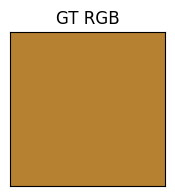

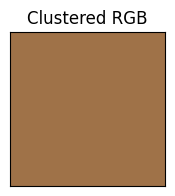

In [ ]:
clustered_rgb = stream_sort(filtered_splats)
print(f"Clustered RGB value at ({x}, {y}): {clustered_rgb}")

diff = rgb_diff(gt_rgb_value, clustered_rgb)
print("Clustering: The difference from ground truth values is:", diff)

# Show ground truth
gt_rgb_color = (gt_rgb_value[0] / 255, gt_rgb_value[1] / 255, gt_rgb_value[2] / 255)
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_facecolor(gt_rgb_color)
ax.set_xticks([])
ax.set_yticks([])
plt.title("GT RGB")
plt.show()

# Show clustered result
c_rgb_color = (clustered_rgb[0] / 255, clustered_rgb[1] / 255, clustered_rgb[2] / 255)
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_facecolor(c_rgb_color)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Clustered RGB")
plt.show()

### Entire Image Processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# Function to cluster and compute final RGB values
def cluster_numpy(splats):
    # Group by depth using a tolerance for clustering
    sorted_indices = np.argsort(splats[:, 1])  # Sort by depth
    splats = splats[sorted_indices]

    clustered_depths = []
    clustered_values = []
    cluster = []

    for i in range(len(splats)):
        if len(cluster) == 0 or abs(splats[i, 1] - cluster[-1, 1]) < 0.11:
            cluster.append(splats[i])
        else:
            cluster = np.array(cluster)
            clustered_depths.append(cluster[:, 1].mean())  # Average depth
            clustered_values.append(cluster)
            cluster = [splats[i]]

    # Add the last cluster
    if cluster:
        cluster = np.array(cluster)
        clustered_depths.append(cluster[:, 1].mean())
        clustered_values.append(cluster)

    # Compute final RGB
    final_r = final_g = final_b = 0.0
    final_t = 1.0

    for cluster in clustered_values:
        alphas = cluster[:, 0]
        colors = cluster[:, 2:5]
        cluster_color = np.sum((final_t * alphas[:, None] * colors), axis=0)
        cluster_alpha = 1 - np.prod(1 - alphas)

        if cluster_alpha > 0:
            cluster_color /= cluster_alpha

        final_r += final_t * cluster_alpha * cluster_color[0]
        final_g += final_t * cluster_alpha * cluster_color[1]
        final_b += final_t * cluster_alpha * cluster_color[2]

        final_t *= (1 - cluster_alpha)
        if final_t <= 0:
            break

    return (
        np.clip(final_r * 255, 0, 255).astype(np.uint8),
        np.clip(final_g * 255, 0, 255).astype(np.uint8),
        np.clip(final_b * 255, 0, 255).astype(np.uint8),
    )

# Load the image for dimensions
image = Image.open('/content/drive/MyDrive/3dgs/data/pre-trained/3DGS/playroom/train/ours_30000/renders/00020.png')
width, height = image.size  # Image dimensions
reconstructed_image = np.zeros((height, width, 3), dtype=np.uint8)  # Empty image array

# Get the CSV data from Polars DataFrame
splats = df.to_numpy()

# Extract pixel positions (column 0)
x = (splats[:, 0] % width).astype(int)
y = (splats[:, 0] // width).astype(int)

# Extract splat data (all Gaussian data)
splat_data = splats[:, 1:].reshape(-1, 5)

# Cluster and compute RGB for each pixel
clustered_rgb = cluster_numpy(splat_data)

# Populate the image array
for i in tqdm(range(len(x)), desc="Processing Pixels"):
    if 0 <= x[i] < width and 0 <= y[i] < height:  # Ensure the indices are within bounds
        reconstructed_image[y[i], x[i]] = clustered_rgb[i]

# Convert the pixel array to an image
final_image = Image.fromarray(reconstructed_image)

# Display the reconstructed image
plt.figure(figsize=(10, 8))
plt.imshow(final_image)
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Optionally, save the image
final_image.save("/content/reconstructed_image.png")
print("Reconstructed image saved!")